# Exogenous variables (features)


Exogenous variables are predictors that are independent of the model being used for forecasting, and their future values must be known in order to include them in the prediction process. The inclusion of exogenous variables can enhance the accuracy of forecasts.

In skforecast, exogenous variables can be easily included as predictors in all forecasting models. To ensure that their effects are accurately accounted for, it is crucial to include these variables during both the training and prediction phases. This will help to optimize the accuracy of forecasts and provide more reliable predictions.

<p style="text-align: center">
    <img src="../img/matrix_transformation_with_exog_variable.png" style="width: 500px;">
    <br>
    <font size="2.5"> <i>Time series transformation including an exogenous variable.</i></font>
</p>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When exogenous variables are included in a forecasting model, it is assumed that all exogenous inputs are known in the future. Do not include exogenous variables as predictors if their future value will not be known when making predictions.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

For a detailed guide on how to include categorical exogenous variables, please visit <a href="../user_guides/categorical-features.html">Categorical Features</a>.

</div>

## Libraries and data

In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from feature_engine.timeseries.forecasting import WindowFeatures
from feature_engine.timeseries.forecasting import LagFeatures
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 3)


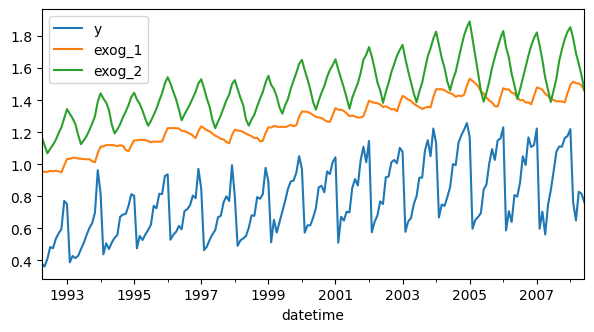

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=False)
data.index.name = 'datetime'

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data.plot(ax=ax)
plt.show()

In [4]:
# Split data in train and test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

## Train forecaster with exogenous variables

In [5]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 15
             )

forecaster.fit(
    y    = data_train['y'],
    exog = data_train[['exog_1', 'exog_2']]
)

forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: None 
Window size: 15 
Exogenous included: True 
Exogenous names: exog_1, exog_2 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-21 12:09:07 
Last fit date: 2024-11-21 12:09:08 
Skforecast version: 0.14.0 
Python version: 3.12.4 
Forecaster id: None

## Prediction

If the `Forecaster` has been trained using exogenous variables, they should be provided during the prediction phase.

In [6]:
# Predict
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_test[['exog_1', 'exog_2']]
              )

predictions.head(3)

2005-07-01    1.023969
2005-08-01    1.044023
2005-09-01    1.110078
Freq: MS, Name: pred, dtype: float64

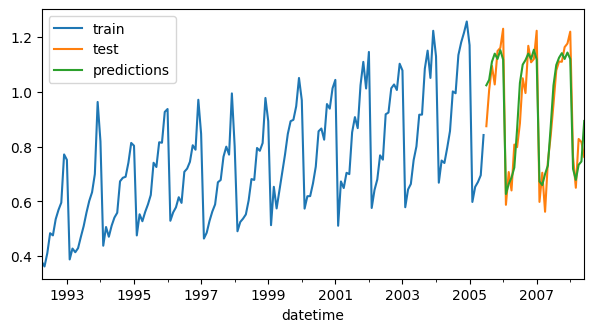

In [7]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.show()

In [8]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.005576949968874203


## Feature importances

If exogenous variables are included as predictors, they have a value of feature importances.

In [9]:
# Feature importances with exogenous variables
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
11,lag_12,66
15,exog_1,49
16,exog_2,37
10,lag_11,36
5,lag_6,31
13,lag_14,26
4,lag_5,26
2,lag_3,25
14,lag_15,24
12,lag_13,23


## Handling missing exogenous data in initial training periods

When working with time series models that incorporate exogenous variables, it’s common to encounter cases where exogenous data isn't available for the very first part of the historical dataset. This can raise concerns, especially since these initial observations are essential for creating predictors and training matrices. However, full alignment between the exogenous variables and the time series data is only necessary after this initial window period.

In practical terms, this means that if you have missing exogenous values in the early part of your data, they won't prevent model training as long as your exogenous variables are aligned from the point where predictors are created (after the first `window_size` observations).

In [10]:
# Window required by the Forecaster to create predictors
# ==============================================================================
window_size = forecaster.window_size
print("Window size required by the Forecaster:", window_size)

Window size required by the Forecaster: 15


A exogenous variable which skips the first `window_size` observations of the time series is simulated.

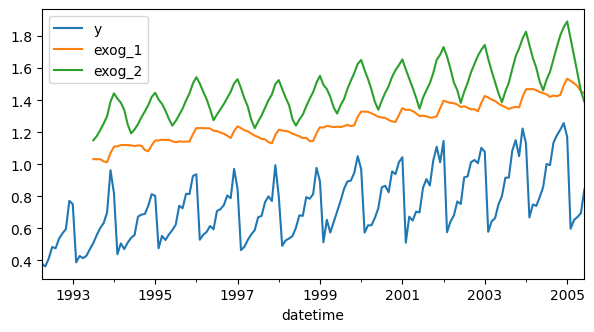

In [11]:
# Simulate data
# ==============================================================================
exog_no_first_window_size = data_train[['exog_1', 'exog_2']].copy()
exog_no_first_window_size = exog_no_first_window_size.iloc[window_size:, :]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
data_train[['y']].plot(ax=ax)
exog_no_first_window_size.plot(ax=ax)
plt.show()

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 15
             )

forecaster.fit(
    y    = data_train['y'],
    exog = exog_no_first_window_size[['exog_1', 'exog_2']]
)

# Predict
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_test[['exog_1', 'exog_2']]
              )
predictions.head(3)

2005-07-01    1.023969
2005-08-01    1.044023
2005-09-01    1.110078
Freq: MS, Name: pred, dtype: float64

In [13]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.005576949968874203


Since the training matrices are the same as those used with the full exogenous variables, the resulting model is the same and the predictions are identical.

In [14]:
# Check training matrices are the same with both methods
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 15
             )

X_train_full_exog, y_train_full_exog = forecaster.create_train_X_y(
    y    = data_train['y'],
    exog = data_train[['exog_1', 'exog_2']]
)

X_train_no_full_exog, y_train_no_full_exog = forecaster.create_train_X_y(
    y    = data_train['y'],
    exog = exog_no_first_window_size[['exog_1', 'exog_2']]
)

pd.testing.assert_frame_equal(X_train_full_exog, X_train_no_full_exog)
pd.testing.assert_series_equal(y_train_full_exog, y_train_no_full_exog)

## Lagged values and window features from exogenous variables

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
  This section focuses on lagged values and window features derived from past values of the exogenous variables. These features are different from the window features derived from series being forecasted. See the 
  <a href="../user_guides/window-features-and-custom-features.html">Window and custom features</a> for more information on the latter.
</p>

</div>

In [15]:
# Downloading data
# ==============================================================================
data = fetch_dataset(name='bike_sharing', raw=False)
data = data.loc[:, ['users', 'holiday', 'temp', 'windspeed']]
data.head(3)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,users,holiday,temp,windspeed
date_time,,,,
2011-01-01 00:00:00,16.0,0.0,9.84,0.0
2011-01-01 01:00:00,40.0,0.0,9.02,0.0
2011-01-01 02:00:00,32.0,0.0,9.02,0.0


Combining the [<code>LagFeatures</code>](https://feature-engine.trainindata.com/en/latest/user_guide/timeseries/forecasting/LagFeatures.html#lagfeatures) and [<code>WindowFeatures</code>](https://feature-engine.trainindata.com/en/latest/api_doc/timeseries/forecasting/WindowFeatures.html) from feature-engine library, it is straightforward to create lagged values and window features from exogenous variables. In this example, the last 3 lagged values aswell as the mean and standard deviation of the last 24 values are extracted from the exogenous variable `temp` and `windspeed`.

In [16]:
# Create lagged features and rolling windows features from exogenous variables
# ==============================================================================
lag_transformer = LagFeatures(
                    variables = ["temp", "windspeed"],
                    periods   = [1, 2, 3],
                  )

wf_transformer = WindowFeatures(
                    variables      = ["temp", "windspeed"],
                    window         = ["24h"],
                    functions      = ["mean"],
                    freq           = "h",
                    missing_values = "ignore",
                    drop_na        = False,
                )

exog_transformer = make_pipeline(
                        wf_transformer,
                        lag_transformer
                   )

exog_transformer

Pipeline(steps=[('windowfeatures',
                 WindowFeatures(freq='h', functions=['mean'],
                                missing_values='ignore',
                                variables=['temp', 'windspeed'],
                                window=['24h'])),
                ('lagfeatures',
                 LagFeatures(periods=[1, 2, 3],
                             variables=['temp', 'windspeed']))])

In [17]:
data = exog_transformer.fit_transform(data)
data.head(5)

,users,holiday,temp,windspeed,temp_window_24h_mean,windspeed_window_24h_mean,temp_lag_1,windspeed_lag_1,temp_lag_2,windspeed_lag_2,temp_lag_3,windspeed_lag_3
date_time,,,,,,,,,,,,
2011-01-01 00:00:00,16.0,0.0,9.84,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,40.0,0.0,9.02,0.0,9.840000,0.0,9.84,0.0,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,32.0,0.0,9.02,0.0,9.430000,0.0,9.02,0.0,9.84,0.0,NaN,NaN
2011-01-01 03:00:00,13.0,0.0,9.84,0.0,9.293333,0.0,9.02,0.0,9.02,0.0,9.84,0.0
2011-01-01 04:00:00,1.0,0.0,9.84,0.0,9.430000,0.0,9.84,0.0,9.02,0.0,9.02,0.0


## Backtesting with exogenous variables

All the backtesting strategies available in skforecast can also be applied when incorporating exogenous variables in the forecasting model. Visit the [Backtesting section](../user_guides/backtesting.html#backtesting-with-exogenous-variables) for more information.